In [1]:
import os
from tqdm import tqdm
import pandas as pd 
import numpy as np

import re
import string
from textblob import TextBlob
from bs4  import BeautifulSoup

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

#Lemmatizing and POSTagging

from nltk import pos_tag
from nltk.tag.stanford import StanfordPOSTagger
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk_lemmatizer = WordNetLemmatizer()

from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

punct = set(string.punctuation)
modalVerb =['can', 'could', 'may', 'might', 'will', 'would', 'shall', 'should', 'must']
stopWords = set(stopwords.words('english'))
stopWords.remove('not')
stopWords.remove('can')
stopWords.remove('will')
# REMOVE SINGLE ALPHABET a, e, s etc ..
    

tqdm.pandas() 
import pickle

Using TensorFlow backend.


# Initializing and decalring constant
* Stanford POS tagger importing

In [2]:
stopWords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same

In [3]:
java_path = "C:/Program Files/Java/jdk1.8.0_201/bin/java.exe"
os.environ['JAVAHOME'] = java_path
#os.environ['STANFORD_POSTAGGER'] = "C:/Users/Me/Documents/stanford-postagger-full-2018-10-16"
os.environ['STANFORD_POSTAGGER'] = "D:/NLP/Library file/stanford-postagger-full-2018-10-16"
Stanford_postagger = StanfordPOSTagger(os.environ['STANFORD_POSTAGGER'] +'/models/english-bidirectional-distsim.tagger',os.environ['STANFORD_POSTAGGER']+'/stanford-postagger.jar')

# importing Data and exploring

In [4]:
df= pd.read_csv("D:\dataset\Sentiment analysis Data\imdb_master.csv",encoding='cp1252')

In [5]:
df.tail()

,Unnamed: 0,type,review,label,file
99995,99995,train,"Delightfully awful! Made by David Giancola, a ...",unsup,9998_0.txt
99996,99996,train,"Watching Time Chasers, it obvious that it was ...",unsup,9999_0.txt
99997,99997,train,At the beginning we can see members of Troma t...,unsup,999_0.txt
99998,99998,train,"The movie was incredible, ever since I saw it ...",unsup,99_0.txt
99999,99999,train,"TCM came through by acquiring this wonderful, ...",unsup,9_0.txt


In [6]:
#dropping uncessary columns
#df.drop(df['Unnamed: 0','file'],axis =1)

In [7]:
df.columns

Index(['Unnamed: 0', 'type', 'review', 'label', 'file'], dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
Unnamed: 0    100000 non-null int64
type          100000 non-null object
review        100000 non-null object
label         100000 non-null object
file          100000 non-null object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


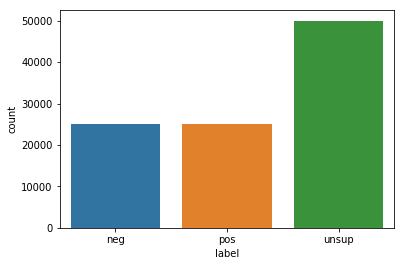

In [9]:
sns.countplot(df["label"])

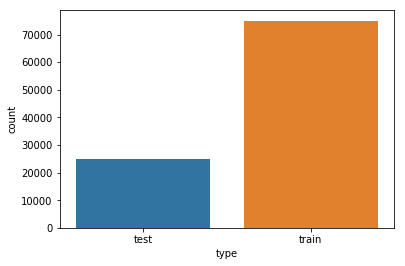

In [10]:
#df.groupby("label").describe()
sns.countplot(df["type"])

In [11]:
df["type"].value_counts()

train    75000
test     25000
Name: type, dtype: int64

# so summary 1
label = ['neg','pos','unsup']
        #25K  , #25K   , # 50K
type= ['test','train']
        #25 , # 75
        
# NEG = 0 and POS = 1 and unlabel = 2
    

In [12]:
def word_count_in_review(review):
    tokens = word_tokenize(review)
    return len(tokens)  

def encodeLabel(label):
    if label == "neg":
        return pd.to_numeric('0.0',downcast='float')
    elif label == "pos":
        return pd.to_numeric('1.0',downcast='float')
    elif label == "unsup":
        return pd.to_numeric('2.0',downcast='float')

In [13]:
%%time
df["word_count"] = df["review"].progress_apply(lambda x : word_count_in_review(x))

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:19<00:00, 719.02it/s]


Wall time: 2min 19s


In [14]:
df['label_encode'] =  df['label'].progress_apply(lambda x : encodeLabel(x))

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 25686.49it/s]


In [15]:
df.head()

,Unnamed: 0,type,review,label,file,word_count,label_encode
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt,187,0.0
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt,274,0.0
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt,278,0.0
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt,343,0.0
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt,286,0.0


# Freq dist plot and Statistics of text data

In [16]:
#freq distribution lenght of data
def stats_of_freq_distribution(freq_column):
    print("MEAN length of data set :",np.mean(freq_column))
    print("MEDIAN length of data set :",np.median(freq_column))
    print("STD DEV length of data set :",np.std(freq_column))
    print("MAX token of data set :",np.max(freq_column))
    print("MIN token of data set :",np.min(freq_column))
    
def plot_length_distribution(freq_column):
    plt.hist(freq_column, bins=50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()


# Wordcount before preprocessing

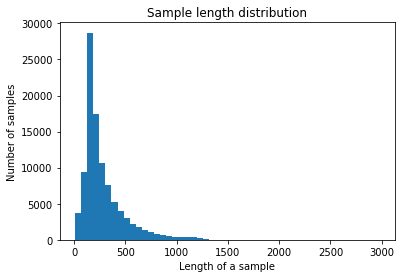

In [17]:
plot_length_distribution(df['word_count'])

In [18]:
#mean length of data set
stats_of_freq_distribution(df['word_count'])

MEAN length of data set : 281.28154
MEDIAN length of data set : 210.0
STD DEV length of data set : 209.37237094523337
MAX token of data set : 2977
MIN token of data set : 8


# test data =>  from 0 to df.iloc[24999] 
# train dat   => from 25k to df.iloc[49999] 
# unsup data  => from df.iloc[50000]
**neg = 0 and pos = 1 and  unsup = 2**

In [19]:
df.iloc[24999] 

Unnamed: 0                                                  24999
type                                                         test
review          I've seen this story before but my kids haven'...
label                                                         pos
file                                                      9_7.txt
word_count                                                    239
label_encode                                                    1
Name: 24999, dtype: object

In [20]:
#stpword1 = ['a', 'about' , 'an' , 'are', 'as', 'at', 'be','by','com','de','en','for','from','how','i','in','is','it','la','of','on','or','that', 'the', 'this'  , 'to' , 'was', 'what' , 'when', 'where', 'who', 'will', 'with', 'und', 'the' , 'www'   ]

In [21]:
df.head()

,Unnamed: 0,type,review,label,file,word_count,label_encode
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt,187,0.0
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt,274,0.0
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt,278,0.0
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt,343,0.0
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt,286,0.0


# PreProcess step1

In [22]:
def replace_contraction(text):
    contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'can not'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'),
                            (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),(r'(\w+)\'ve', '\g<1> have'),
                            (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), 
                            (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not'),
                            (r'br', ' '),(r'www', ' '),
                            (r'http\S+', ' '),(r"#(\w+)", ' '),(r"@(\w+)", ' '),(r'[^\w\s]', ' ')                            
                           ]

    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

#can run spell checker
# before punct removal of https <br> /n etc ..
# not removed stop word
#contradiction handling from below link
# pos tag
#lemmatization
#find max_length to detect freq distribution

def preProcess(text):
    
    soup = BeautifulSoup(text)
    text =soup.get_text()
    
    tokens = word_tokenize(text) 
    #lowercase
    tokens = [t.lower() for t in tokens]                                     #incas if its U.S untd state, IFB
    # rmv that are not alphabet
    tokens = [word for word in tokens if not word.isdigit()]
    #rmv token that are of length 1
    tokens = [word for word in tokens if len(word) > 1]
    #rmv stopword
    tokens = [word for word in tokens if word not in stopWords]
    
    return ' '.join(text for text in tokens if text not in punct)

# https://mlwhiz.com/blog/2019/01/17/deeplearning_nlp_preprocess/

In [23]:
df_preprocessed = pd.DataFrame()

In [24]:
%%time
df_preprocessed["review"] = df["review"].progress_apply(lambda x : preProcess(replace_contraction(x)))

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:42<00:00, 616.22it/s]


Wall time: 2min 42s


# Preprocess Handle POS and lemmatization step 2

In [25]:
# You need to convert the tag from the pos_tagger to one of the four "syntactic categories" that wordnet recognizes,
# then pass that to the lemmatizer as the word_pos.
# so lemmatizer can process it

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None 
    
#tagged is defined globally

def nltk_lemma(tag):
    global tagged
    lst=[]
    for word, tag in tagged:
        
        wntag = get_wordnet_pos(tag)
        
        if wntag is None:# not supply tag in case of None
            lemma = nltk_lemmatizer.lemmatize(word)
            lst.append(lemma)
            #return " ".join(lemma)
            #print(lemma)
        else:
            lemma = nltk_lemmatizer.lemmatize(word, pos=wntag)
            lst.append(lemma)
            #return " ".join(lemma)
            #print(lemma)
            
    return lst


def POS_lemmatize(review):
    global tagged
    #normal tagger
    tagged = pos_tag(word_tokenize(review))
    #stanford tagger
    #tagged = Stanford_postagger.tag(word_tokenize(review))# imp word tokenize and repective POS
    return " ".join(nltk_lemma(tagged))# retuns setence after lemmatising

# Here using normal pos_tag as stanford is giving error****

In [26]:
#using pos_tag and not he stanford tagger
#%%time
df_preprocessed['review'] = df_preprocessed["review"].progress_map(lambda x : POS_lemmatize(x) )

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [10:53<00:00, 152.93it/s]


In [27]:
%%time
df_preprocessed['sentiment'] = df['label_encode']
df_preprocessed["word_count"] = df_preprocessed["review"].progress_apply(lambda x : word_count_in_review(x))

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:46<00:00, 2161.25it/s]


Wall time: 46.3 s


In [32]:
# testing 49460
#earlier after processsing
'''
great gangster filmsam mendes direct beautiful movie show another fatherson camaraderiebrilliant starcast lead tom 
hanksmichael sullivan do terrific jobgreat act againhe act legendgreat act paul newmanjude law daniel craigcasting goodthe
plot quite goodyou enjoy moviea great portrayal gangster isset isthis surely stand zenith gangster movie 
erasoundtrack pretty good apt moviea great flick totality show father protect sonway underrated likingdeserved fully deserve
'''
df_preprocessed['review'].iloc[49458]

'great gangster film sam mendes direct beautiful movie show another father son camaraderie brilliant star cast lead tom hank michael sullivan do terrific job great act act legend great act paul newman jude law daniel craig cast good plot quite good enjoy movie great portrayal gangster set surely stand zenith gangster movie era soundtrack pretty good apt movie great flick totality show father protect son way underrated liking deserve fully deserve'

In [33]:
df_preprocessed.columns

Index(['review', 'sentiment', 'word_count'], dtype='object')

# Org. data plot VS processed data plot

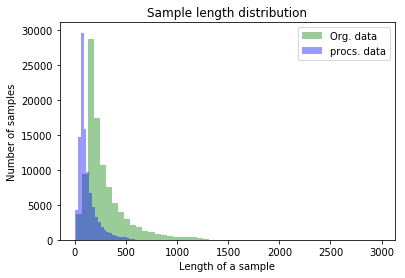

In [34]:
plt.hist(df['word_count'], bins=50,color='green',alpha=0.4, label="Org. data" )
plt.hist(df_preprocessed['word_count'], bins=50,color='blue',alpha=0.4,label="procs. data")
plt.xlabel('Length of a sample')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.legend()
plt.show()

# Shuffle DataFrame rows 1st 50 k 

In [35]:
df_preprocessed[0:49999] = df_preprocessed[0:49999].sample(frac=1).reset_index(drop=True)

In [36]:
df_preprocessed.head(10)

,review,sentiment,word_count
0,granny best movie ever ganny best movie ever s...,1.0,68
1,always want see film finally get knew nice sur...,1.0,63
2,story potential good film difficult choice lov...,0.0,62
3,belongs top tier although others micro phony p...,1.0,74
4,ief review contain spoiler since movie spoil w...,0.0,60
5,wait superhero movie like long time mystery me...,1.0,442
6,lurk couple year never move post perhaps movie...,0.0,305
7,adventure barry mckenzie start life satirical ...,1.0,383
8,first saw movie come watch recently still funn...,1.0,160
9,let start say surprised production value movie...,1.0,165


# Deciding seq length

In [37]:
stats_of_freq_distribution(df_preprocessed['word_count'][0:49999])

MEAN length of data set : 118.12740254805097
MEDIAN length of data set : 88.0
STD DEV length of data set : 89.4035897990274
MAX token of data set : 1405
MIN token of data set : 3


In [41]:
max_tokens = 118 + 2 * 88
max_tokens

294

# number of sentence above 294 sequnce from top 50k data

In [55]:
print(len(df_preprocessed[df_preprocessed['word_count'] > 294][0:49999]  ))

5740


In [44]:
np.sum(df_preprocessed['word_count'][0:49999] < max_tokens) / len(df_preprocessed['word_count'][0:49999])

0.9440788815776315

In [56]:
pd.to_pickle(df_preprocessed, "./pickle/V1_preProcessed.pkl")

In [ ]:
#POS_lemmatize("Pickle does need to recursively walk your trie. If Pickle is using just 5 levels of function calls to do the work your trie of depth 638 will need the level set to more than 3000")

In [ ]:
#picle location = D:\NLP\andrew\nlp\8. State of the arts\25000 data pre processings